# TS2Vec based time series representation

![image](TS2Vec_schema.png)

This file contains an implementation of TS2Vec on a publicly available [ECG200 dataset](https://www.timeseriesclassification.com/description.php?Dataset=ECG200). 
The dataset contains one time series feature of length 96 and 2 classes.
The goal is to  learn a time series representation in an unsupervised or self-supervised such that the learnt representations can be good at the classification task.

Adapted from [official repo of TS2VEC](https://github.com/yuezhihan/ts2vec).

In [73]:
# importing packages
import os
import numpy as np
import pandas as pd
import math
import argparse
import random
import matplotlib.pyplot as plt
import json
import time
import datetime
from ts2vec import TS2Vec
from tasks import eval_classification
import datautils
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout
from sklearn.manifold import TSNE

In [75]:
# check the current directory, set it as ts2vec
if os.getcwd()!= '/home/trips/ContrastiveLearning_Tutorial/ts2vec':  # replace the path with your local path
    os.chdir('/home/trips/ContrastiveLearning_Tutorial/ts2vec')
print("Current working directory is : ", os.getcwd())

Current working directory is :  /home/trips/ContrastiveLearning_Tutorial/ts2vec


In [76]:
# function for initial loading and processing of the dataset
def load_UCR(dataset):
    train_file = os.path.join('../Small_datasets', dataset, dataset + "_TRAIN.tsv")
    test_file = os.path.join('../Small_datasets', dataset, dataset + "_TEST.tsv")
    train_df = pd.read_csv(train_file, sep='\t', header=None)
    test_df = pd.read_csv(test_file, sep='\t', header=None)
    train_array = np.array(train_df)
    test_array = np.array(test_df)

    # Move the labels to {0, ..., L-1}
    labels = np.unique(train_array[:, 0])
    transform = {}
    for i, l in enumerate(labels):
        transform[l] = i

    train = train_array[:, 1:].astype(np.float64)
    train_labels = np.vectorize(transform.get)(train_array[:, 0])
    test = test_array[:, 1:].astype(np.float64)
    test_labels = np.vectorize(transform.get)(test_array[:, 0])

    # Normalization for non-normalized datasets
    # To keep the amplitude information, we do not normalize values over
    # individual time series, but on the whole dataset
    if dataset not in [
        'AllGestureWiimoteX',
        'AllGestureWiimoteY',
        'AllGestureWiimoteZ',
        'BME',
        'Chinatown',
        'Crop',
        'EOGHorizontalSignal',
        'EOGVerticalSignal',
        'Fungi',
        'GestureMidAirD1',
        'GestureMidAirD2',
        'GestureMidAirD3',
        'GesturePebbleZ1',
        'GesturePebbleZ2',
        'GunPointAgeSpan',
        'GunPointMaleVersusFemale',
        'GunPointOldVersusYoung',
        'HouseTwenty',
        'InsectEPGRegularTrain',
        'InsectEPGSmallTrain',
        'MelbournePedestrian',
        'PickupGestureWiimoteZ',
        'PigAirwayPressure',
        'PigArtPressure',
        'PigCVP',
        'PLAID',
        'PowerCons',
        'Rock',
        'SemgHandGenderCh2',
        'SemgHandMovementCh2',
        'SemgHandSubjectCh2',
        'ShakeGestureWiimoteZ',
        'SmoothSubspace',
        'UMD'
    ]:
        return train[..., np.newaxis], train_labels, test[..., np.newaxis], test_labels
    
    mean = np.nanmean(train)
    std = np.nanstd(train)
    train = (train - mean) / std
    test = (test - mean) / std
    return train[..., np.newaxis], train_labels, test[..., np.newaxis], test_labels

In [64]:
# initial setting and the dataset choice

dataset = "ECG200" # dataset name
run_name = "ECG200_output"  # output data directory
gpu = 0  # what number gpu to use
batch_size=8  
lr=0.001  # learning rate
repr_dims=320  # representation dimension
max_train_length = 3000  # sequence with a length greater than max_train_length would be croppped
seed = 100  # random seed
eval = True  # whether to perform evaluation after training
task_type = 'classification' # evaluation task
irregular = 0 # initial missing observation ratio

In [65]:
# identifying the device
device = init_dl_program(gpu, seed=seed)
print(device)

cuda:0


In [66]:
# loading data
train_data, train_labels, test_data, test_labels = load_UCR(dataset)

# data dimensions 
print(" Training data size :  ", train_data.shape)  # Number of samples * Length of the series * number of features
print(" Test data size :  ", test_data.shape)

 Training data size :   (100, 96, 1)
 Test data size :   (100, 96, 1)


In [67]:
# whether to add missingness to the data or not
if irregular > 0:
    if task_type == 'classification':
        train_data = data_dropout(train_data, irregular)
        test_data = data_dropout(test_data, irregular)
    else:
        raise ValueError(f"Task type {task_type} is not supported when irregular>0.")
print('done')

done


In [68]:
# saving the output models
run_dir = './training/' + dataset + '__' + name_with_datetime(run_name)
os.makedirs(run_dir, exist_ok=True)

In [69]:
config = dict(
    batch_size=batch_size,
    lr=lr,
    output_dims=repr_dims,
    max_train_length=max_train_length
)
t = time.time()

In [70]:
# training the model
model = TS2Vec(
    input_dims=train_data.shape[-1],
    device=device,
    **config
)
loss_log = model.fit(
    train_data,
    verbose=True
)
model.save(f'{run_dir}/model.pkl')

t = time.time() - t
print(f"\nTraining time: {datetime.timedelta(seconds=t)}\n")

Epoch #0: loss=5.793830414613088
Epoch #1: loss=2.430328090985616
Epoch #2: loss=2.1744327346483865
Epoch #3: loss=2.0398612121740975
Epoch #4: loss=2.0319058001041412
Epoch #5: loss=1.93396923939387
Epoch #6: loss=1.9788636565208435
Epoch #7: loss=1.8434793949127197
Epoch #8: loss=1.831672191619873
Epoch #9: loss=1.7620827158292134
Epoch #10: loss=1.764383872350057
Epoch #11: loss=1.6286860009034474
Epoch #12: loss=1.8195396065711975
Epoch #13: loss=1.7917581995328267
Epoch #14: loss=1.7114560703436534
Epoch #15: loss=1.6288898487885792

Training time: 0:00:09.824257



In [71]:
# obtain the train and test data embeddings
train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
test_repr = model.encode(test_data, encoding_window='full_series' if train_labels.ndim == 1 else None)

## Visualize the embeddings using t-sne

/home/trips/Virtual_env_python/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


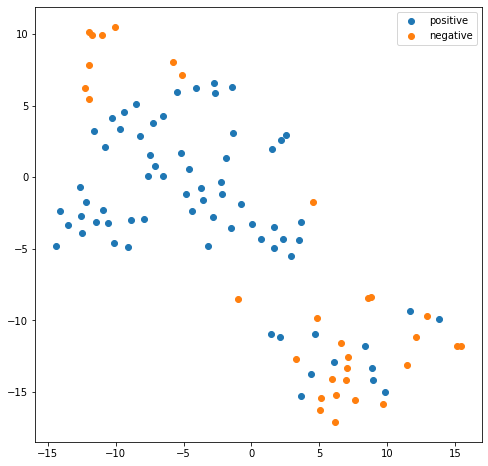

In [74]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_repr)
positive = train_labels == 1

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

## Linear evaluation

In [56]:
# Linear evaluation of the model
out, eval_res = eval_classification(model, train_data, train_labels, test_data, test_labels, eval_protocol='svm')

TypeError: eval_classification() missing 2 required positional arguments: 'includePreops' and 'outcome'

In [57]:
eval_classification

<function tasks.classification.eval_classification(model, train_data, train_labels, test_data, test_labels, includePreops, outcome, eval_protocol='xgbt')>

In [58]:
pwd

'/home/trips/ContrastiveLearning_Tutorial/ts2vec'

In [59]:
TS2Vec

ts2vec.TS2Vec